In [38]:

import os
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from joblib import dump, load
from xgboost import XGBRegressor , plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor  # For regression tasks
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score



In [39]:
import hopsworks

# Get the API key from GitHub Secrets
HOPSWORKS_API_KEY = os.getenv('HOPSWORKS_API_KEY')

# with open('hopsworks-api-key.txt', 'r') as file:
#     os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

In [40]:
project = hopsworks.login(project="ScalableMLandDeepLcourse")
fs = project.get_feature_store()

2024-12-29 15:25:19,005 INFO: Closing external client and cleaning up certificates.
Connection closed.
2024-12-29 15:25:19,020 INFO: Initializing external client
2024-12-29 15:25:19,021 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-29 15:25:20,167 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1170582


## 3.Write a training pipeline

### 3.1 Get datas from features groups

In [41]:
# Load the Feature Groups for air quality and weather data
trafic_fg = fs.get_feature_group(name="stockholm_traffic", version=1)
weather_fg = fs.get_feature_group(name="stockholm_weather_holiday", version=1)

# Read the data from both feature groups
trafic_df = trafic_fg.read()
weather_df = weather_fg.read()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.93s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.60s) 


## Data Filtering

### Delete not exploitable datas

In [42]:
cutoff_date = pd.Timestamp("2024-12-19 09:00:00+00:00")
trafic_df = trafic_df[trafic_df["date"] >= cutoff_date]

In [43]:
weather_df = weather_df[weather_df["date"] >= cutoff_date]

### One hot vector for FRC and coordinates

In [44]:

# Label Encoding
label_encoder_FRC = LabelEncoder()

trafic_df["FRC"] = label_encoder_FRC.fit_transform(trafic_df["frc"])

# Supprimer l'ancienne colonne frc
trafic_df = trafic_df.drop(columns=["frc"])


In [45]:
# Label Encoding
label_encoder_coor = LabelEncoder()

trafic_df["SEG"] = label_encoder_coor.fit_transform(trafic_df["coordinates"])

# Supprimer l'ancienne colonne coordinates
trafic_df = trafic_df.drop(columns=["coordinates"])

### Add the label (the relative speed for the following hour)

In [46]:
trafic_df["relativespeed_h1"] = (
    trafic_df.sort_values("date").groupby("SEG")["relativespeed"].shift(-1)  # Décalage pour +1H dans chaque segment
)


### Join both datas

In [47]:
merged_df = pd.merge(trafic_df, weather_df, on="date", how="inner")

In [48]:
merged_df = merged_df.dropna()

In [49]:
merged_df['heure'] = pd.to_datetime(merged_df['date']).dt.hour

In [50]:
merged_df = merged_df.drop(columns=["date"],axis=1)

In [51]:
merged_df

,currentspeed,freeflowspeed,currenttraveltime,freeflowtraveltime,confidence,roadclosure,relativespeed,FRC,SEG,relativespeed_h1,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,holiday_status,heure
0,32,32,35,35,1.00,False,1.000000,3,91,0.709677,8.226,3.926,0.8,22.68,232.057388,0,9
1,13,18,133,96,0.92,False,0.722222,6,129,1.000000,8.226,3.926,0.8,22.68,232.057388,0,9
2,13,13,104,104,1.00,False,1.000000,5,1,0.692308,8.226,3.926,0.8,22.68,232.057388,0,9
3,20,20,125,125,1.00,False,1.000000,6,21,1.000000,8.226,3.926,0.8,22.68,232.057388,0,9
4,26,26,99,99,1.00,False,1.000000,3,126,0.600000,8.226,3.926,0.8,22.68,232.057388,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38839,23,23,23,23,1.00,False,1.000000,3,106,1.000000,7.876,6.026,0.3,33.48,243.379440,0,13
38840,21,21,25,25,1.00,False,1.000000,5,45,1.000000,7.876,6.026,0.3,33.48,243.379440,0,13
38841,19,19,22,22,1.00,False,1.000000,6,4,1.000000,7.876,6.026,0.3,33.48,243.379440,0,13
38842,17,28,120,73,0.99,False,0.607143,4,51,0.814815,7.876,6.026,0.3,33.48,243.379440,0,13


### 3.4 Split datas

In [52]:
# Séparation des caractéristiques (X) et du label (y)
X = merged_df.drop(columns=["relativespeed_h1"])  # Caractéristiques
y = merged_df["relativespeed_h1"]  # Label (cible)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42  # 20% des données pour le test
)

# Affichage des tailles des ensembles
print("Taille de X_train :", X_train.shape)
print("Taille de X_test :", X_test.shape)
print("Taille de y_train :", y_train.shape)
print("Taille de y_test :", y_test.shape)

Taille de X_train : (27190, 16)
Taille de X_test : (11654, 16)
Taille de y_train : (27190,)
Taille de y_test : (11654,)


### 3.5 Train the model with the training split


In [53]:
# XGBOOST / RANDOM Forest at first (maybe use Random Search for hyperparameters tunning )

In [54]:
# Creating an instance of the XGBoost Regressor
tree_regressor = DecisionTreeRegressor(random_state=42)

# Fitting the XGBoost Regressor to the training data
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

### 3.6 Infere on the test split and evaluate

In [55]:
# Predicting target values on the test set
y_pred_train = tree_regressor.predict(X_train)
y_pred_test = tree_regressor.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
print(f"Train MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")

Train MSE: 0.00
Test MSE: 0.04


In [56]:
# Combiner les labels réels et les prédictions dans un DataFrame
comparison_df = pd.DataFrame({
    "Actual": y_test[:30].values,       # Les 10 premières valeurs réelles
    "Predicted": y_pred_test[:30]      # Les 10 premières prédictions
})

# Afficher les résultats côte à côte
print(comparison_df)

      Actual  Predicted
0   1.000000   1.000000
1   1.000000   1.000000
2   0.631579   1.000000
3   1.000000   1.000000
4   1.000000   0.527778
5   1.000000   1.000000
6   1.000000   0.812500
7   1.000000   1.000000
8   1.000000   1.000000
9   1.000000   1.000000
10  0.588235   1.000000
11  0.194444   0.384615
12  1.000000   1.000000
13  1.000000   1.000000
14  1.000000   1.000000
15  1.000000   1.000000
16  1.000000   0.791667
17  0.612903   0.566667
18  1.000000   1.000000
19  1.000000   1.000000
20  1.000000   0.809524
21  1.000000   1.000000
22  1.000000   1.000000
23  1.000000   1.000000
24  1.000000   1.000000
25  1.000000   1.000000
26  0.650000   1.000000
27  0.476190   1.000000
28  1.000000   1.000000
29  1.000000   1.000000


In [57]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "trafic_pred_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

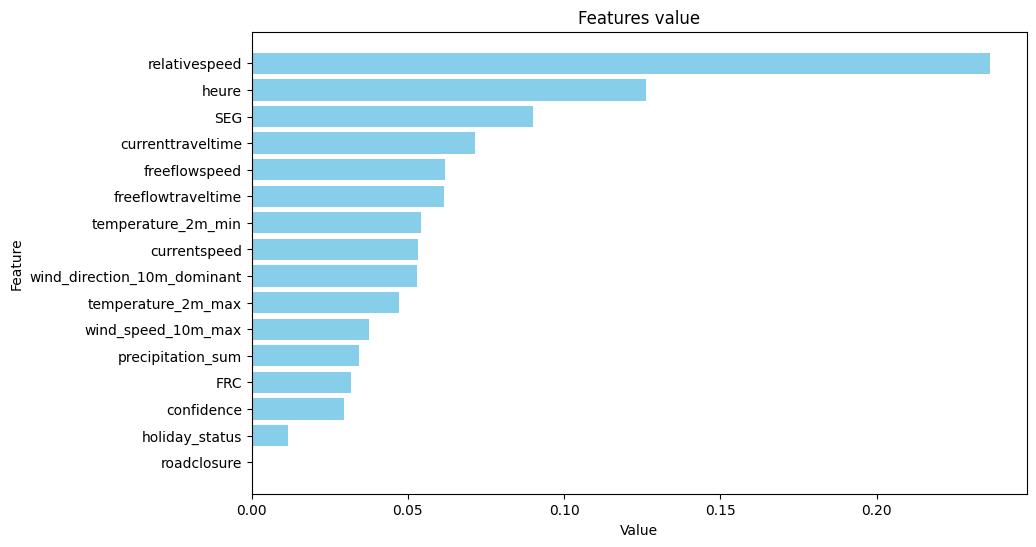

In [58]:
# Plotting feature importances using the plot_importance function from XGBoost
# Récupérer les importances des caractéristiques
feature_importances = tree_regressor.feature_importances_

# Associer les importances aux noms des caractéristiques
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)


# Visualiser les importances sous forme de graphique
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Value")
plt.ylabel("Feature")
plt.title("Features value")
plt.gca().invert_yaxis()
plt.show()

### 3.7 Save the model

In [59]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [60]:

# Save the model
dump(tree_regressor, model_dir + "/decision_tree_model.joblib")




['trafic_pred_model/decision_tree_model.joblib']

In [61]:
res_dict = { 
        "MSE_train": str(train_mse),
        "MSE_test": str(test_mse),
    }

In [63]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named ''

traffic_model = mr.python.create_model(
    name="trafic_pred_tree", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Traffic Patterns predictor with regression tree",
)

# Saving the model artifacts to the 'dtree_model' directory in the model registry
traffic_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/1366135 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/149 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1398 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1170582/models/trafic_pred_tree/1


Model(name: 'trafic_pred_tree', version: 1)